***Group 21***
- Jiaming Chang
- Shangshang Chen
- Dhruv Kochar
- Michael Tumbelaka

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as stats
import random
from scipy.stats import norm

## **Problem Statement**:  
Given the data, determine the net annual renenvue of Blue Chip Cafe.

## **Variables and parameters**:  
| Description | Symbol | Units | Type|
|-------------|--------|-------|-----|
|Daily temperature | $T$ | $^\circ C$ | Random variable|
|Number of Customer (daily)| $C$ | $person$ | Random variable|
|Daily precipitation| $P$| $millimeters$ | Random variable|
|Net annual revenue |$R$ | $\$$ | Random variable|
|Income per customer's purchace |$C_i$ | $\$$ | parameter|
|The rate of change of customers with respect to temperature|$a$ | $\frac{person}{^\circ C}$ | parameter|
|he rate of change of customers with respect to precipitation|$b$ | $\frac{person}{millimeters}$ | parameter|
|Uncertainty in a| $\varepsilon_{a}$ | $1$ | Random variable|
|Uncertainty in b| $\varepsilon_b$ | $1$ | Random variable|
|The reference number of customers| $C_0$ | $persons$ | Constant|
|The reference temperature| $T_0$ | $^\circ C$ | Constant|
|The reference precipitation| $P_0$ | $millimeters$ | Constant|

## **Assumptions and Constraints:**  
***Assumptions:***  
- The uncertainty associated with each parameter is normally distributed with mean $0$ and $\sigma$ equal to the level of uncertainty.
- The Blue Chip does not run out of food or drink to sell.
- The Cafe is open all year (expect for the 13 days for holidays)
- Customer count depends linearly on deviations in temperature and precipitation. 
- Temperature and precipitation independently influence customer count, without any interactive effects.
- Each day's weather would not affect the number of customers in other days.
- The March 2024 customer frequency data is assumed to reflect general customer behavior across the year.   

***Constraints:***  
- Final customer count is constrained to be non-negative.
- Each customer would pay only for one drink and one cookie.
- The price for drink is $\$3.17$, and the price for a cookie is $\$3.5$.
- The reference number of customers is the average of daily number of customers from thew customers dataset
- The reference temperature is the overall average temperature from the vancouver weather dataset, and the reference precipitation is the overall average precipitation from the vancouver weather dataset. 


## **Build Solutions:**  
The Net Income is:
\begin{align*}
\textrm{Net Income} 
& = R \\
& = \textrm{Total Revenue}\\
& = (365-13)*C*(C_i)\\
& = 352*C*(C_i)\\
\end{align*}

We then define the following:
\begin{align*}
C(T,P) &= max\{c(T,P),0\}\\
c(T,P) &= C_0 + a(T-T_0)-b(P-P_0)\\
\hat{a} &= a + \varepsilon_{a}\\
\hat{b} &= b + \varepsilon_b\\
\hat{C}(T,P) &= max\{\hat{c}(T,P),0\}\\
\hat{c}(T,P) &= C_0 + \hat{a}(T-T_0)-\hat{b}(P-P_0)\\
\end{align*}

The model is then:

$$ R = 352*\hat{C}*(C_i)$$

To obtain $a$ and $b$, we observe that $a$ represents the rate of change of customers with respect to temperature, and $b$ represents the rate of change of customers with respect to precipitation.   
Variance describes how the data deviates from its mean value, which could be used as a measurement of change of one variable.   
Therefore, we assume that $a \sim \frac{variance(customer)}{variance(temperature)}$, and  $b \sim \frac{variance(customer)}{variance(precipitation)}$   
To estimate $a$ and $b$, we use dataset for monthly frequency of customers in March and dataset for vancouver weather.   


In [41]:
# import data
customer_df = pd.read_csv('data/customer.csv')
weather_df = pd.read_csv('data/vancouver_weather.csv')

customer_df_daily = customer_df["Monthly_Frequency_Customers"].div(31)
print("The variance of customer is ", customer_df_daily.var())
print("The variance of temperature is ", weather_df["avg_temperature"].var())
print("The variance of precipitation is ", weather_df["precipitation"].var())
a = customer_df_daily.var()/weather_df["avg_temperature"].var()
b = customer_df_daily.var()/ weather_df["precipitation"].var()
err_a = round(0.1*a,2)
err_b = round(0.1*b,2)
print("The error of a is about",err_a)
print("The error of b is about",err_b)

The variance of customer is  101.05937991942152
The variance of temperature is  34.256797689996276
The variance of precipitation is  41.88987356712415
The error of a is about 0.3
The error of b is about 0.24


We know that such estimation is not accurate, so we added the error term for $a$ and $b$, the error is about $10\%$ of their value. So we have:  
\begin{align*}
\varepsilon_a &\sim \mathcal{N}(0,(0.3)^2)\\
\varepsilon_b &\sim \mathcal{N}(0,(0.24)^2)\\
\end{align*}

In [42]:
# distribution of daily average temperature
temp_kde = stats.gaussian_kde(weather_df['avg_temperature'])
# distribution of average daily precipitation
precip_kde = stats.gaussian_kde(weather_df["precipitation"])

In [51]:
## c(T,P) = C_0 + a(T-T_0) - b(P-P_0)

T_0 = weather_df['avg_temperature'].mean()
P_0 = weather_df['precipitation'].mean()
C_0 = customer_df_daily.sum().mean()

In [68]:
#### Monte Carlo

t = np.linspace(1,352,352)
N = 500
Net_income_mc = []
Net_income_determin = []
income_per_person = 6.67 #3.17+3.5

for i in range(N): 
    net_income_year = []
    net_income_year_det = []
    net_income = 0
    net_income_det = 0
    for _ in range(352):
        T = temp_kde.resample(1).item()
        P = precip_kde.resample(1).item()
        a_mc = a + np.random.normal(loc=0.0, scale=err_a,size=1).item()
        b_mc = b + np.random.normal(loc=0.0, scale=err_b,size=1).item()
        customer = C_0 + a_mc* (T-T_0) - b_mc * (P-P_0)
        Num_customer = np.maximum(customer, 0)
        net_income += Num_customer * income_per_person
        net_income_year.append(net_income)
        # deterministic
        customer_det = C_0 + a* (T-T_0) - b* (P-P_0)
        Num_customer_det = np.maximum(customer_det, 0)
        net_income_det += Num_customer_det * income_per_person
        net_income_year_det.append(net_income_det)
    # plt.plot(t,net_income_year,'-c',alpha=0.3,linewidth=0.5)
    Net_income_mc.append(net_income_year)
    Net_income_determin.append(net_income_year_det)
    
Net_income_mc_ave = np.array(Net_income_mc)
Net_income_det_ave = np.array(Net_income_determin)
# plt.plot(t,Net_income_mc_ave.mean(axis=0),'r',linewidth=1,label='Average') 
# plt.plot(t,Net_income_det_ave.mean(axis=0), ':b',linewidth=1.5,label='Deterministic')
# plt.legend()
# plt.grid(True)
# plt.show()

In [69]:
Net_income_mc_end = Net_income_mc_ave[:,-1] #create a vertical slice at the last entry

# plt.hist(Net_income_mc_end,bins=np.arange(400000,500000,1000),density=True,alpha=0.5)
kde1 = stats.gaussian_kde(Net_income_mc_end)
kde2 = stats.gaussian_kde(Net_income_mc_end,bw_method=1)
kde3 = stats.gaussian_kde(Net_income_mc_end,bw_method=0.1)

# x = np.arange(400000,500000,1000)
# plt.plot(x,kde1(x),label='h = {:.2f}'.format(kde1.factor))
# plt.plot(x,kde2(x),label='h = 1.00')
# plt.plot(x,kde3(x),label='h = 0.10')
# plt.title('Kernel Density Functions (Gaussian)')
# plt.legend()
# plt.grid(True)
# plt.show()


## probabilility that we make at least $430000 profit 
prob1 = kde1.integrate_box_1d(430000,np.inf)
prob2 = kde2.integrate_box_1d(430000,np.inf)
prob3 = kde3.integrate_box_1d(430000,np.inf)

print(prob1,prob2,prob3)

0.930355061740422 0.8671505951153127 0.9348668709846815


## **Analyze and Assess**

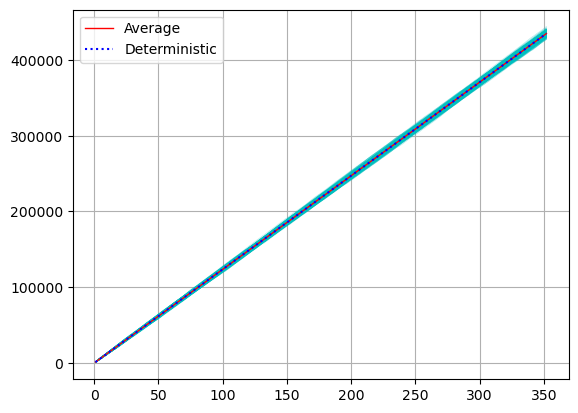

In [58]:
## case when a has no uncertainty
t = np.linspace(1,352,352)
N = 500
Net_income_mc = []
Net_income_determin = []
income_per_person = 6.67 #3.17+3.5

for i in range(N): 
    net_income_year = []
    net_income_year_det = []
    net_income = 0
    net_income_det = 0
    for _ in range(352):
        T = temp_kde.resample(1).item()
        P = precip_kde.resample(1).item()
        a_mc = a #+ np.random.normal(loc=0.0, scale=err_a,size=1).item()
        b_mc = b + np.random.normal(loc=0.0, scale=err_b,size=1).item()
        customer = C_0 + a_mc* (T-T_0) - b_mc * (P-P_0)
        Num_customer = np.maximum(customer, 0)
        net_income += Num_customer * income_per_person
        net_income_year.append(net_income)
        # deterministic
        customer_det = C_0 + a* (T-T_0) - b* (P-P_0)
        Num_customer_det = np.maximum(customer_det, 0)
        net_income_det += Num_customer_det * income_per_person
        net_income_year_det.append(net_income_det)
    plt.plot(t,net_income_year,'-c',alpha=0.3,linewidth=0.5)
    Net_income_mc.append(net_income_year)
    Net_income_determin.append(net_income_year_det)
    
Net_income_mc_ave = np.array(Net_income_mc)
Net_income_det_ave = np.array(Net_income_determin)
plt.plot(t,Net_income_mc_ave.mean(axis=0),'r',linewidth=1,label='Average') 
plt.plot(t,Net_income_det_ave.mean(axis=0), ':b',linewidth=1.5,label='Deterministic')
plt.legend()
plt.grid(True)
plt.show()

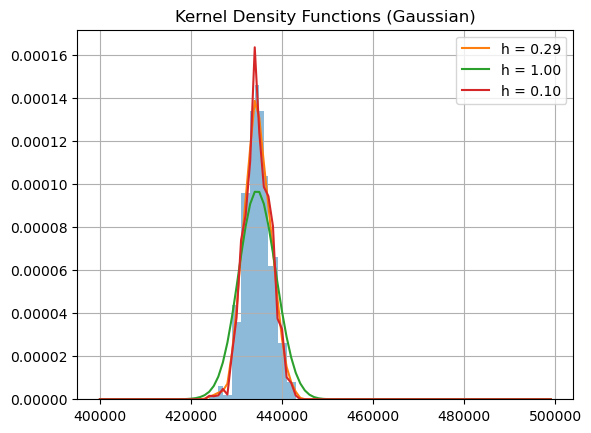

0.941661389708076 0.869089210278701 0.9452228323418952


In [63]:
Net_income_mc_end = Net_income_mc_ave[:,-1] #create a vertical slice at the last entry

plt.hist(Net_income_mc_end,bins=np.arange(400000,500000,1000),density=True,alpha=0.5)
kde1 = stats.gaussian_kde(Net_income_mc_end)
kde2 = stats.gaussian_kde(Net_income_mc_end,bw_method=1)
kde3 = stats.gaussian_kde(Net_income_mc_end,bw_method=0.1)

x = np.arange(400000,500000,1000)
plt.plot(x,kde1(x),label='h = {:.2f}'.format(kde1.factor))
plt.plot(x,kde2(x),label='h = 1.00')
plt.plot(x,kde3(x),label='h = 0.10')
plt.title('Kernel Density Functions (Gaussian)')
plt.legend()
plt.grid(True)
plt.show()


## probabilility that we make at least $430000 profit 
prob1 = kde1.integrate_box_1d(430000,np.inf)
prob2 = kde2.integrate_box_1d(430000,np.inf)
prob3 = kde3.integrate_box_1d(430000,np.inf)

print(prob1,prob2,prob3)

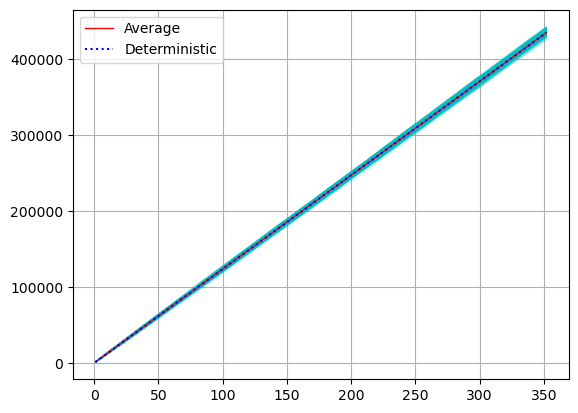

In [61]:
## case when b has no uncertainty

t = np.linspace(1,352,352)
N = 500
Net_income_mc = []
Net_income_determin = []
income_per_person = 6.67 #3.17+3.5

for i in range(N): 
    net_income_year = []
    net_income_year_det = []
    net_income = 0
    net_income_det = 0
    for _ in range(352):
        T = temp_kde.resample(1).item()
        P = precip_kde.resample(1).item()
        a_mc = a + np.random.normal(loc=0.0, scale=err_a,size=1).item()
        b_mc = b #+ np.random.normal(loc=0.0, scale=err_b,size=1).item()
        customer = C_0 + a_mc* (T-T_0) - b_mc * (P-P_0)
        Num_customer = np.maximum(customer, 0)
        net_income += Num_customer * income_per_person
        net_income_year.append(net_income)
        # deterministic
        customer_det = C_0 + a* (T-T_0) - b* (P-P_0)
        Num_customer_det = np.maximum(customer_det, 0)
        net_income_det += Num_customer_det * income_per_person
        net_income_year_det.append(net_income_det)
    plt.plot(t,net_income_year,'-c',alpha=0.3,linewidth=0.5)
    Net_income_mc.append(net_income_year)
    Net_income_determin.append(net_income_year_det)
    
Net_income_mc_ave = np.array(Net_income_mc)
Net_income_det_ave = np.array(Net_income_determin)
plt.plot(t,Net_income_mc_ave.mean(axis=0),'r',linewidth=1,label='Average') 
plt.plot(t,Net_income_det_ave.mean(axis=0), ':b',linewidth=1.5,label='Deterministic')
plt.legend()
plt.grid(True)
plt.show()

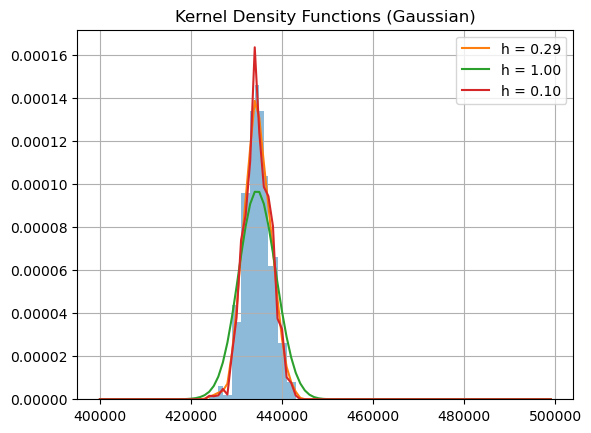

0.941661389708076 0.869089210278701 0.9452228323418952


In [64]:
Net_income_mc_end = Net_income_mc_ave[:,-1] #create a vertical slice at the last entry

plt.hist(Net_income_mc_end,bins=np.arange(400000,500000,1000),density=True,alpha=0.5)
kde1 = stats.gaussian_kde(Net_income_mc_end)
kde2 = stats.gaussian_kde(Net_income_mc_end,bw_method=1)
kde3 = stats.gaussian_kde(Net_income_mc_end,bw_method=0.1)

x = np.arange(400000,500000,1000)
plt.plot(x,kde1(x),label='h = {:.2f}'.format(kde1.factor))
plt.plot(x,kde2(x),label='h = 1.00')
plt.plot(x,kde3(x),label='h = 0.10')
plt.title('Kernel Density Functions (Gaussian)')
plt.legend()
plt.grid(True)
plt.show()


## probabilility that we make at least $430000 profit 
prob1 = kde1.integrate_box_1d(430000,np.inf)
prob2 = kde2.integrate_box_1d(430000,np.inf)
prob3 = kde3.integrate_box_1d(430000,np.inf)

print(prob1,prob2,prob3)

## **Conclusion and Report**
- According to the model, Blue Chip Cafe would most likely to have an total annual revenue between the range of $\$$420000 to $\$$440000.
- According to the model, the Blue Chip Cafe would have 94$\%$ chance of making at least $\$$430000 profit. 
- It is noticable that the uncertainty in the rate of change of customers with respect to temperature (a) and uncertainty in the rate of change of customers with respect to precipitation (b) does not effect the overall annual revenue too much. When compared to the actual report for Blue Chip Cafe profit ($\$$810000 in 2023/2024), even the best of the simulation projects for a revenue of around $\$$440000. This is due to the assumption on the items each customer would purchase, the reference number of customers, reference temperature, and reference precipitation. Those assumption restrict the algorithm to accurately simulate daily number of customers and renevnue.
- Increase the uncertainty level changes the results, but the result is not significant. Such result is realistic, because the simulation also depends on the income from each customer's purchase and the randomness from temperature/precipitation. Only changing the uncertainty level for the two coefficients would not make a big difference in the simulation results.

***Sources used:***  
- The price for food and drink come from the official Menu: https://www.ams.ubc.ca/wp-content/uploads/2024/07/2024-BlueChip-Menu-Summer.pdf
- the actual revenue for reference is from the Ubyssey article: https://ubyssey.ca/news/blue-chip-location-opens-after-lengthy-relocation-process/